## Following the tutorial
- https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585

49


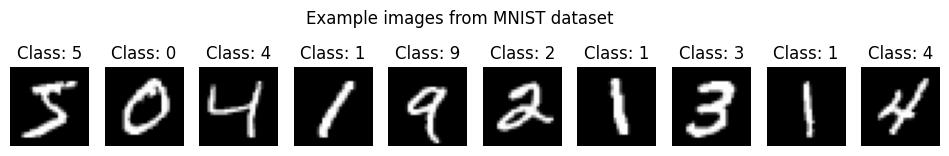

In [135]:
import torch
import numpy as np
from torchvision.transforms import v2, ToPILImage
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

img_size = 28
patch_size = 4
mask_ratio = 0.5
num_patches = (img_size//patch_size)**2

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cpu")

transform = v2.Compose([v2.PILToTensor()])
# Load MNIST dataset
X_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
X_test = datasets.MNIST('../data', train=False, download=True, transform=transform)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input.squeeze(), cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

In [100]:
def extract_patches(img, patch_size):
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

def apply_mask(imgs, mask_ratio):
    batch_size = imgs.shape[0]
    num_patches = imgs.shape[1]-1
    mask_count = int(num_patches * mask_ratio)
    masks = torch.zeros(batch_size, num_patches).long()

    for i in range(batch_size):
        mask_idx = torch.randperm(num_patches)[:mask_count]
        masks[i, mask_idx] = 1  # Set the selected indices to 1 (mask)
    
    return masks

# Returns a tensor of size [batch_size, num_patches, patch_size, patch_size]
def collate_fn(batch):
    images, _ = zip(*batch)
    imgs = np.array([np.asarray(image) for image in images]) / 255.0
    imgs = torch.tensor(imgs, dtype=torch.float32)
    # imgs = torch.cat([extract_patches(img, patch_size) for img in imgs], dim=1)
    return imgs

batch_size = 128
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True,  collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=False,  collate_fn=collate_fn)


## Encoder

In [121]:
import torch.nn as nn
import torch

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_dim: int = 768, img_size: int = 224):
        super().__init__()
        self.patch_size = patch_size
        self.emb_dim = emb_dim
        
        # Conv2d layer to extract patches and map to emb_size dimensions
        self.projection = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)
        
        # Classification token (learnable parameter)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        
        # Positional embeddings for all patches + cls token
        num_patches = (img_size // patch_size) ** 2
        self.positions = nn.Parameter(torch.randn(num_patches+1, emb_dim))  # +1 for cls_token
        
    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)  # [b, emb_size, h', w'] where h' = h // patch_size
        
        x = x.permute(0, 2, 3, 1)  # [b, h', w', emb_size]
        x = x.reshape(b, -1, self.emb_dim)  # [b, h' * w', emb_size]
        
        cls_tokens = self.cls_token.expand(b, -1, -1)  # [b, 1, emb_size]
        
        x = torch.cat([cls_tokens, x], dim=1)  # [b, (h' * w') + 1, emb_size]
        # Step 5: Add positional embeddings
        x = x + self.positions  # [b, (h' * w') + 1, emb_size]
        
        return x

img = next(iter(train_loader))
pe = PatchEmbedding(in_channels=1, emb_dim=768, patch_size=4, img_size = 28)
x = pe(img)

masks = apply_mask(x, mask_ratio=0.75)

## Try with only one image and embedding

In [132]:
input_tokens = x[0]
cls_token = x[0][-1].unsqueeze(0)
mask = masks[0]
print(input_tokens.shape, mask.shape)

tokens = input_tokens[:-1][mask == 0]
tokens = torch.cat([cls_token, tokens])
# cls + masked tokens
print(tokens.shape)

torch.Size([50, 768]) torch.Size([49])
torch.Size([14, 768])


## Transformer encoder

In [126]:
from timm.models.vision_transformer import Block
embed_dim = 768
block = Block(embed_dim, num_heads=12)
block
encodings = block(tokens.unsqueeze(0)).squeeze(0)
encodings.shape

torch.Size([14, 768])

## Decoder

In [157]:
mask.shape, encodings.shape
#(torch.Size([49]), torch.Size([14, 768]))

decoder_embed_dim = 512
decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
decoder_tokens = decoder_embed(encodings)
decoder_tokens.shape #torch.Size([14, 512])

torch.Size([14, 512])

## Add mask

In [158]:
mask_token = nn.Parameter(torch.zeros(1, decoder_embed_dim))
torch.nn.init.normal_(mask_token, std=.02)
mask_token.shape #torch.Size([1, 512])

tokens = torch.zeros((num_patches, decoder_embed_dim))
tokens[~mask.bool()] = decoder_tokens[1:, :]
tokens[mask.bool()] = torch.cat([mask_token]*(num_patches-(~mask.bool()).sum()))
tokens.shape #torch.Size([49, 512])

torch.Size([49, 512])

In [162]:
decoder_pos_embed = nn.Parameter(torch.zeros(num_patches, decoder_embed_dim))
print(decoder_pos_embed.shape) #torch.Size([49, 512])

tokens = tokens+decoder_pos_embed
tokens.shape #torch.Size([49, 512])

tokens = torch.cat([decoder_tokens[:1, :], tokens])
tokens.shape #torch.Size([50, 512])


torch.Size([49, 512])


torch.Size([50, 512])

In [163]:
decoder_num_heads = 8
decoder_block = Block(decoder_embed_dim, decoder_num_heads, 4, qkv_bias=True, norm_layer=nn.LayerNorm)
decoder_block
out_tokens = decoder_block(tokens.unsqueeze(0)).squeeze(0)
out_tokens.shape #torch.Size([50, 512])

decoder_norm = nn.LayerNorm(decoder_embed_dim)
decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2* (num_patches) * 1, bias=True) # decoder to patch
decoder_pred

Linear(in_features=512, out_features=784, bias=True)

In [164]:
out = decoder_norm(out_tokens.unsqueeze(0)).squeeze(0)
# predictor projection
out = decoder_pred(out)
out.shape #torch.Size([50, 3072])
final_img_predictions = out[1:, :]#remove mask tokens
final_img_predictions.shape #torch.Size([49, 3072])

torch.Size([49, 784])